In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
import string
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import re
from nltk.tokenize import word_tokenize
from tqdm import tqdm

2023-03-26 10:02:43.065753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# read the data
path = '/Users/nautim/Desktop/CEU DNDS/Winter 22:23/Diving into public space/data_project/' # use your path

terror231222 = pd.read_csv(path+'combined_cleaned/terror231222_datausers_cleaned.csv.gz', compression='gzip', dtype='str')
terror230421 = pd.read_csv(path+'combined_cleaned/terror230421_datausers_cleaned.csv.gz', compression='gzip', dtype='str')
terror291020 = pd.read_csv(path+'combined_cleaned/terror291020_datausers_cleaned.csv.gz', compression='gzip', dtype='str')
terror281019 = pd.read_csv(path+'combined_cleaned/terror281019_datausers_cleaned.csv.gz', compression='gzip', dtype='str')

Combining all dataframes into one dataframe

In [128]:
# merge all four datasets into one
terror = pd.concat([terror231222.assign(dataset='terror231222'), 
                    terror230421.assign(dataset='terror230421'), 
                    terror291020.assign(dataset='terror291020'), 
                    terror281019.assign(dataset='terror281019')], ignore_index=True)

terror = terror.drop(columns=['Unnamed: 0'])

In [130]:
terror.created_at = pd.to_datetime(terror.created_at)

Cleaning and Preprocessing

In [131]:
# specify the language of the stopwords and the lemmatizer
french_stopwords = nltk.corpus.stopwords.words('french')
lemmatizer = FrenchLefffLemmatizer()

# the following stopwords are removed from the list of stopwords because they are important in the context of the tweets 

deselect_stop_words = ['ne','pas','plus','aucun','ni','aucune','rien']
for w in deselect_stop_words:
    if w in french_stopwords:
        french_stopwords.remove(w)
    else:
        continue
french_stopwords.append(['rt', 'a'])

In [132]:
def clean_twitter_token(row):
    row = re.sub(r"RT|(@[A-Za-z0-9_]+)|#|http\S+", "", row).strip().lower() # remove RT, @mentions, hashtags, urls, spaces before and after, and convert to lowercase
    row = re.sub(r"[^\w\s]", " ", row).strip().lower() # remove punctiation
    row = nltk.tokenize.word_tokenize(row)
    row = [i for i in row if i not in french_stopwords]
    return row
 
def lemmitized_text(row):
    row = [lemmatizer.lemmatize(i) for i in row]
    return row

stemmer_french = nltk.SnowballStemmer('french')
def stemming_text(row):
    row = [stemmer_french.stem(i) for i in row]
    return row

In [133]:
terror['text_tokenized'] = terror['text'].apply(clean_twitter_token)
terror['text_lemmitized'] = terror['text_tokenized'].apply(lemmitized_text)
terror['tokens_merged'] = terror['text_lemmitized'].apply(lambda x: ' '.join(x))
terror['text_stemm'] = terror['text_tokenized'].apply(stemming_text)

In [134]:
terror_nodups = terror.drop_duplicates(subset=['text'])

In [135]:
print(f"Number of unique tweets: {terror_nodups.shape[0]}\nNumber of all tweets collected: {terror.shape[0]}")

Number of unique tweets: 118576
Number of all tweets collected: 418850


Part about manual labeling - can skip for now!

In [106]:
# merging with manual labels dataset
labels = pd.read_csv(path+'terror_grading.csv', dtype='str')

In [94]:
labels['ideology'].value_counts()

neutral    521
right      506
left       373
Name: ideology, dtype: int64

In [107]:
labels['sentiment_num'] = labels['sentiment'].map({'positive': 2, 'negative': 0, 'neutral': 1})
labels['ideology_num'] = labels['ideology'].map({'right': 2, 'left': 0, 'neutral': 1})

In [60]:
from AugmentedSocialScientist import xlmroberta

No GPU available, using the CPU instead.


Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [108]:
data_train, data_test = xlmroberta.train_test_split(labels, test_size=0.2, random_state=42, stratify=labels['sentiment_num'])

In [109]:
data_test['ideology'].value_counts()

right      103
neutral     96
left        81
Name: ideology, dtype: int64

In [111]:
train_loader = xlmroberta.encode(data_train.text.values, data_train.sentiment_num.values)

  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

In [112]:
test_loader = xlmroberta.encode(data_test.text, data_test.sentiment_num.values)

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

In [113]:
# Better not run - takes around one hour

# score = xlmroberta.run_training(train_loader, 
#                          test_loader, 
#                          n_epochs=2, 
#                          lr=5e-5, 
#                          seed_val=42,
#                          save_model_as='sentiment_trial')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.85
  Training took: 0:27:24

Running Validation...

  Average test loss: 0.80
  Validation took: 0:01:08
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       176
           1       0.00      0.00      0.00        91
           2       0.00      0.00      0.00        13

    accuracy                           0.63       280
   macro avg       0.21      0.33      0.26       280
weighted avg       0.40      0.63      0.49       280


======== Epoch 2 / 2 ========
Training...


/Users/nautim/opt/anaconda3/envs/nautim/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nautim/opt/anaconda3/envs/nautim/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nautim/opt/anaconda3/envs/nautim/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_


  Average training loss: 0.81
  Training took: 0:22:55

Running Validation...

  Average test loss: 0.79
  Validation took: 0:01:07
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       176
           1       0.00      0.00      0.00        91
           2       0.00      0.00      0.00        13

    accuracy                           0.63       280
   macro avg       0.21      0.33      0.26       280
weighted avg       0.40      0.63      0.49       280


Training complete!


/Users/nautim/opt/anaconda3/envs/nautim/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nautim/opt/anaconda3/envs/nautim/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nautim/opt/anaconda3/envs/nautim/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

next part done in a separate notebook

We start with the sentiment analysis based on pre-existing sentiment lexicons and packages. We will use the following lexicons and packages:
*   VADER - rule-based method
*   TextBlob - rule-based method
*   French sentiment analysis with BERT - embedding-based method

In [15]:
# %pip install vaderSentiment-fr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 kB 4.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.3 MB/s eta 0:00:00
  Created wheel for vaderSentiment-fr: filename=vaderSentiment_fr-1.3.4-py3-none-any.whl size=185960 sha256=f8926f94aa84064db93936e564b8f2fe0f13801e920c982ee7c1850356c3ad05
  Stored in directory: /Users/nautim/Library/Caches/pip/wheels/43/f7/64/ce82eef84e7edc8d4925123430bc33078a7045ab7e4f1b89dc
Successfully built vaderSentiment-fr
Note: you may need to restart the kernel to use updated packages.


In [16]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()

/Users/nautim/opt/anaconda3/envs/nautim/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [26]:
# example
sentence = "J'aime beaucoup le chocolat"
SIA.polarity_scores(sentence)
SIA.polarity_scores_max(sentence)['compound']

0.5994

In [136]:
terror_nodups['sentiment_vader'] = terror_nodups['tokens_merged'].apply(lambda x: SIA.polarity_scores(x)['compound'])

/var/folders/6h/3knkk6m91213bg2g5qgpp8h80000gn/T/ipykernel_80488/4177109163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror_nodups['sentiment_vader'] = terror_nodups['tokens_merged'].apply(lambda x: SIA.polarity_scores(x)['compound'])


In [28]:
#%pip install textblob_fr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.2/561.2 kB 8.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [137]:
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [66]:
# example
sentence = "C'est une voiture terribles."
tb(sentence).sentiment

(-0.7, 0.6)

In [138]:
terror_nodups['sentiment_textblob'] = terror_nodups['tokens_merged'].apply(lambda x: tb(x).sentiment[0])

/var/folders/6h/3knkk6m91213bg2g5qgpp8h80000gn/T/ipykernel_80488/655814159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror_nodups['sentiment_textblob'] = terror_nodups['tokens_merged'].apply(lambda x: tb(x).sentiment[0])


In [139]:
# correlate the sentiment scores from Vader and TextBlob
terror_nodups[['sentiment_vader', 'sentiment_textblob']].corr()

,sentiment_vader,sentiment_textblob
sentiment_vader,1.000000,0.234892
sentiment_textblob,0.234892,1.000000


In [142]:
# transform the sentiment scores into a categorical variable (positive, negative, neutral)
terror_nodups['sentiment_vader_cat'] = terror_nodups['sentiment_vader'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))
terror_nodups['sentiment_textblob_cat'] = terror_nodups['sentiment_textblob'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

/var/folders/6h/3knkk6m91213bg2g5qgpp8h80000gn/T/ipykernel_80488/4142391492.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror_nodups['sentiment_vader_cat'] = terror_nodups['sentiment_vader'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))
/var/folders/6h/3knkk6m91213bg2g5qgpp8h80000gn/T/ipykernel_80488/4142391492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terror_nodups['sentiment_textblob_cat'] = terror_nodups['sentiment_textblob'].apply(lambda x: 'pos

In [144]:
# show the confusion matrix for Vader and TextBlob
from sklearn.metrics import confusion_matrix
confusion_matrix(terror_nodups['sentiment_vader_cat'], terror_nodups['sentiment_textblob_cat'])

array([[17429, 24805, 25154],
       [ 1510,  9817,  5962],
       [ 4091, 10518, 19290]])

In [145]:
# print accuracy, precision, and recall scores for Vader and TextBlob
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Accuracy score: {accuracy_score(terror_nodups['sentiment_vader_cat'], terror_nodups['sentiment_textblob_cat'])}")
print(f"Precision score: {precision_score(terror_nodups['sentiment_vader_cat'], terror_nodups['sentiment_textblob_cat'], average='weighted')}")
print(f"Recall score: {recall_score(terror_nodups['sentiment_vader_cat'], terror_nodups['sentiment_textblob_cat'], average='weighted')}")

Accuracy score: 0.3924571582782351
Precision score: 0.5712102113941716
Recall score: 0.3924571582782351


In [162]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine")

nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


In [118]:
# make example sentence
nlp("Bonjour, je ne suis pas contente de vous rencontrer.")[0]['label'].lower()


'negative'

In [7]:
# DO NOT RUN THIS - TAKES AROUND 8 HOURS

# from tqdm import tqdm

# tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
# model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine")

# nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# terror_nodups = pd.read_csv('terror_nodups.csv', dtype='str')

# sentiment_tf = []

# for i in tqdm(range(terror_nodups.shape[0])):
#    sentiment_tf.append(nlp(str(terror_nodups['tokens_merged'].iloc[i]))[0]['label'].lower())

# terror_nodups['sentiment_tf'] = sentiment_tf

In [8]:
# done separately because of time constraints
terror_nodups.sentiment_tf

0         positive
1         positive
2         negative
3         positive
4         positive
            ...   
118571    positive
118572    negative
118573    positive
118574    positive
118575    negative
Name: sentiment_tf, Length: 118576, dtype: object

In [11]:
# group by four date regions and plot changes in sentiment over time for each date region separately

terror_nodups['created_at'] = pd.to_datetime(terror_nodups['created_at'])
terror_nodups['date'] = terror_nodups['created_at'].dt.date

In [12]:
terror_nodups.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'author_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'in_reply_to_user_id',
       'conversation_id', 'text', 'reply_settings', 'possibly_sensitive',
       'place_id', 'place_type', 'coord', 'media_keys', 'retweeted_id',
       'quoted_id', 'replied_id', 'url', 'expanded_url', 'unwound_url',
       'title_url', 'description_url', 'mention_name', 'hashtags',
       'annotations', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'impression_count', 'name', 'username',
       'user_created_at', 'location', 'verified', 'description',
       'user_followers_count', 'user_following_count', 'user_tweet_count',
       'user_listed_count', 'dataset', 'text_tokenized', 'text_lemmitized',
       'tokens_merged', 'text_stemm', 'sentiment_vader', 'sentiment_textblob',
       'sentiment_vader_cat', 'sentiment_textblob_cat', 'date',
       'sentiment_tf'],
      dtype='object')

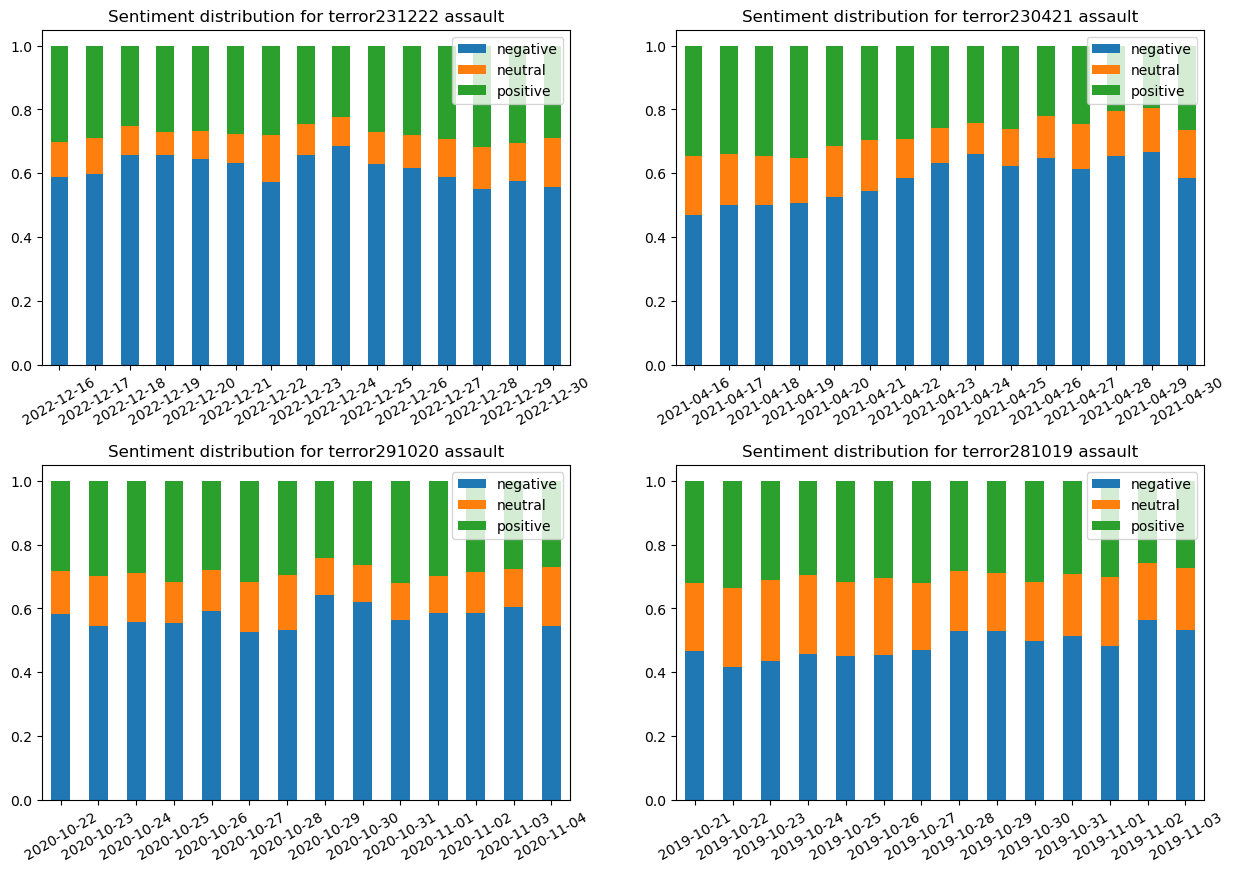

In [21]:
# for each dataset, group by date and plot the filled barplot of sentiment score for each date as subplots
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
for dataset, ax in zip(terror_nodups['dataset'].unique(), axes.flatten()):
    terror_nodups[terror_nodups['dataset'] == dataset].groupby('date')['sentiment_vader_cat'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax, title=f'Sentiment distribution for {dataset} assault')
    ax.set_xlabel('')
    ax.set_ylabel('')
    xlabels = ax.get_xticklabels() 
    ax.set_xticklabels(xlabels, rotation=30)
    ax.legend(loc='upper right')

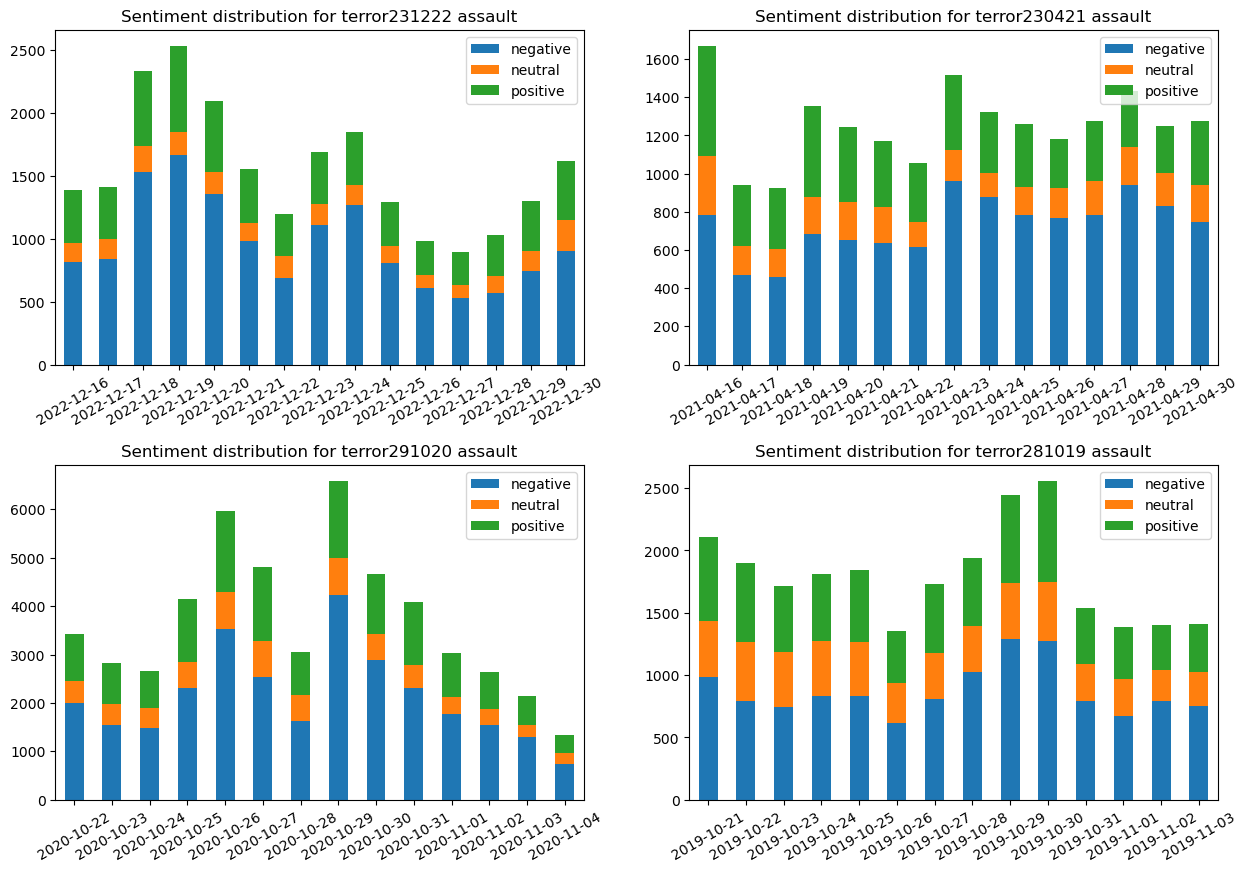

In [22]:
# for each dataset, group by date and plot the filled barplot of sentiment score for each date as subplots
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
for dataset, ax in zip(terror_nodups['dataset'].unique(), axes.flatten()):
    terror_nodups[terror_nodups['dataset'] == dataset].groupby('date')['sentiment_vader_cat'].value_counts().unstack().plot(kind='bar', stacked=True, ax=ax, title=f'Sentiment distribution for {dataset} assault')
    ax.set_xlabel('')
    ax.set_ylabel('')
    xlabels = ax.get_xticklabels() 
    ax.set_xticklabels(xlabels, rotation=30)
    ax.legend(loc='upper right')

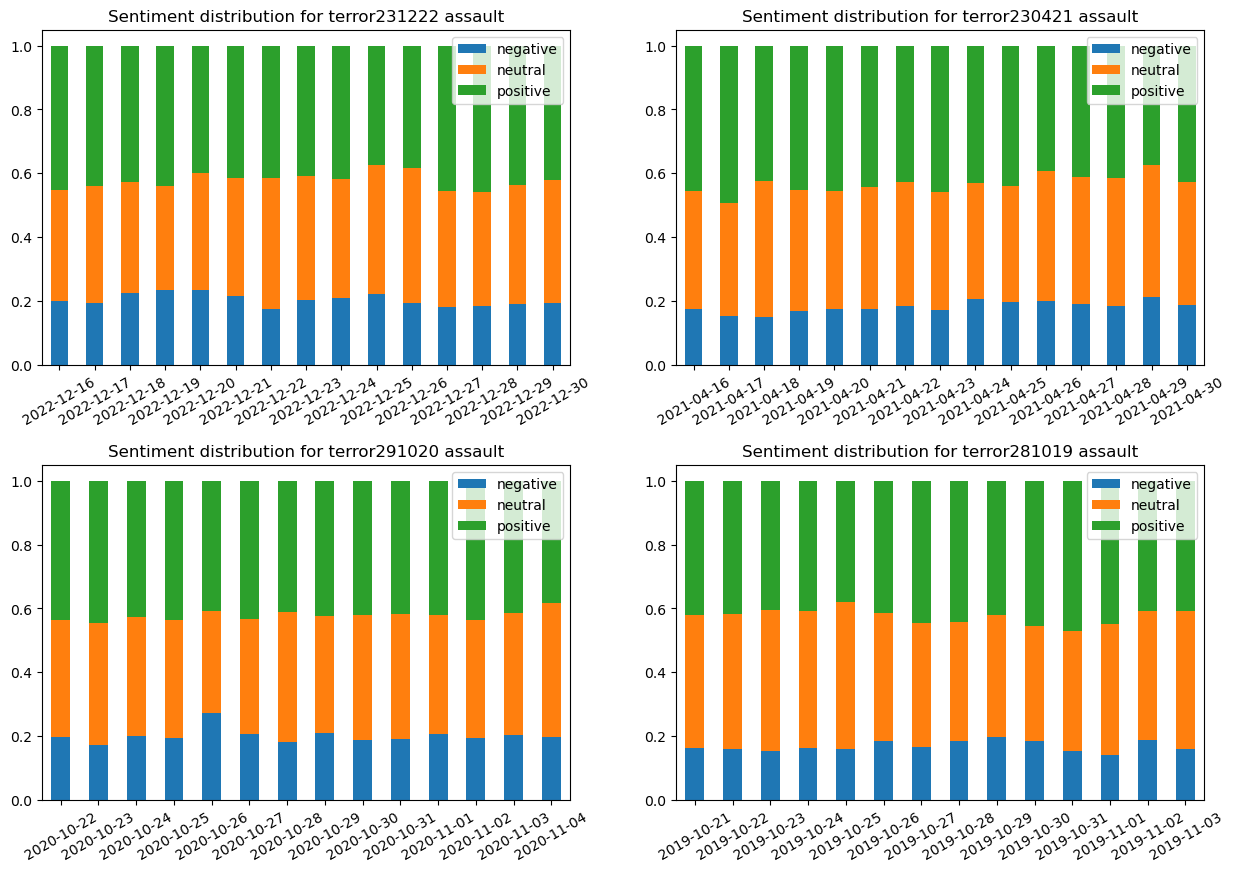

In [23]:
# for each dataset, group by date and plot the filled barplot of sentiment score for each date as subplots
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
for dataset, ax in zip(terror_nodups['dataset'].unique(), axes.flatten()):
    terror_nodups[terror_nodups['dataset'] == dataset].groupby('date')['sentiment_textblob_cat'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax, title=f'Sentiment distribution for {dataset} assault')
    ax.set_xlabel('')
    ax.set_ylabel('')
    xlabels = ax.get_xticklabels() 
    ax.set_xticklabels(xlabels, rotation=30)
    ax.legend(loc='upper right')

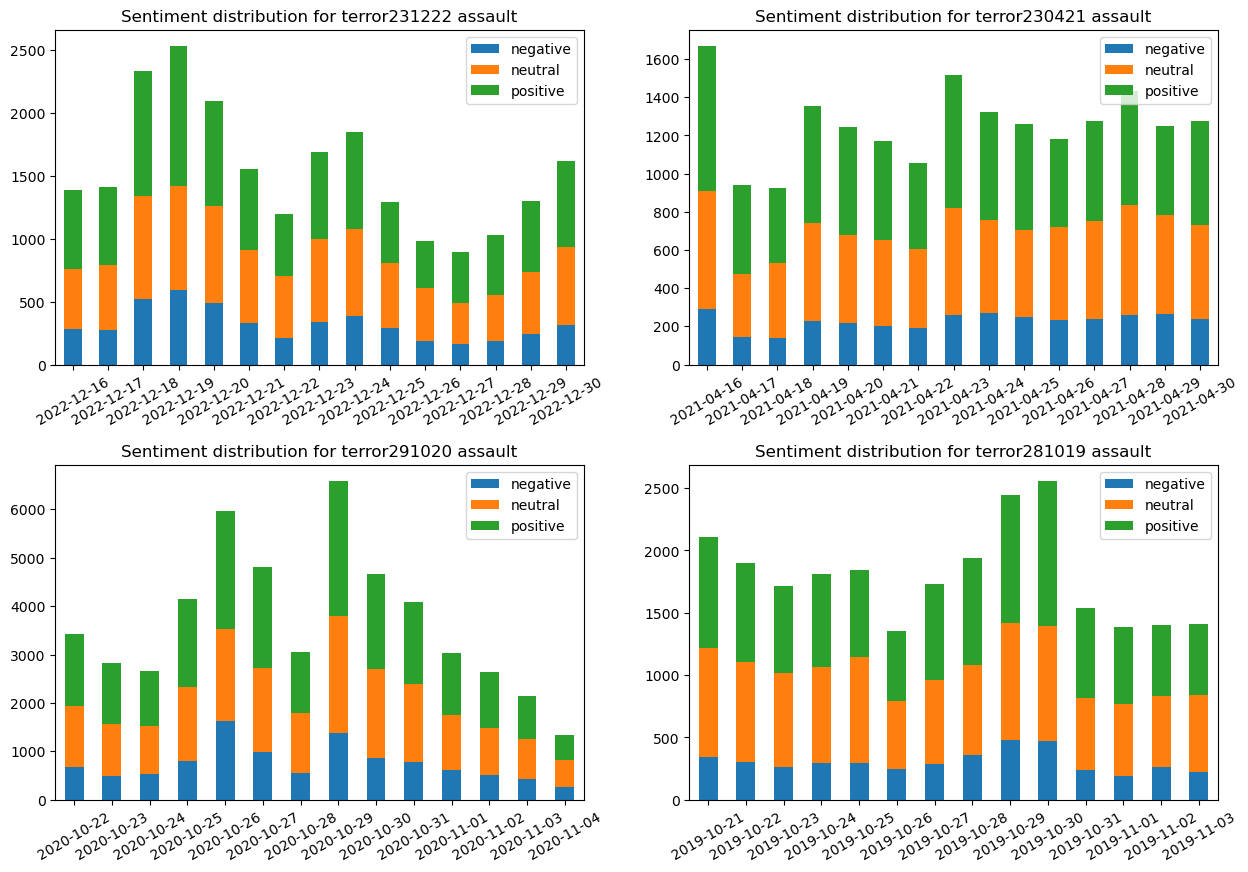

In [24]:
# for each dataset, group by date and plot the filled barplot of sentiment score for each date as subplots
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
for dataset, ax in zip(terror_nodups['dataset'].unique(), axes.flatten()):
    terror_nodups[terror_nodups['dataset'] == dataset].groupby('date')['sentiment_textblob_cat'].value_counts().unstack().plot(kind='bar', stacked=True, ax=ax, title=f'Sentiment distribution for {dataset} assault')
    ax.set_xlabel('')
    ax.set_ylabel('')
    xlabels = ax.get_xticklabels() 
    ax.set_xticklabels(xlabels, rotation=30)
    ax.legend(loc='upper right')

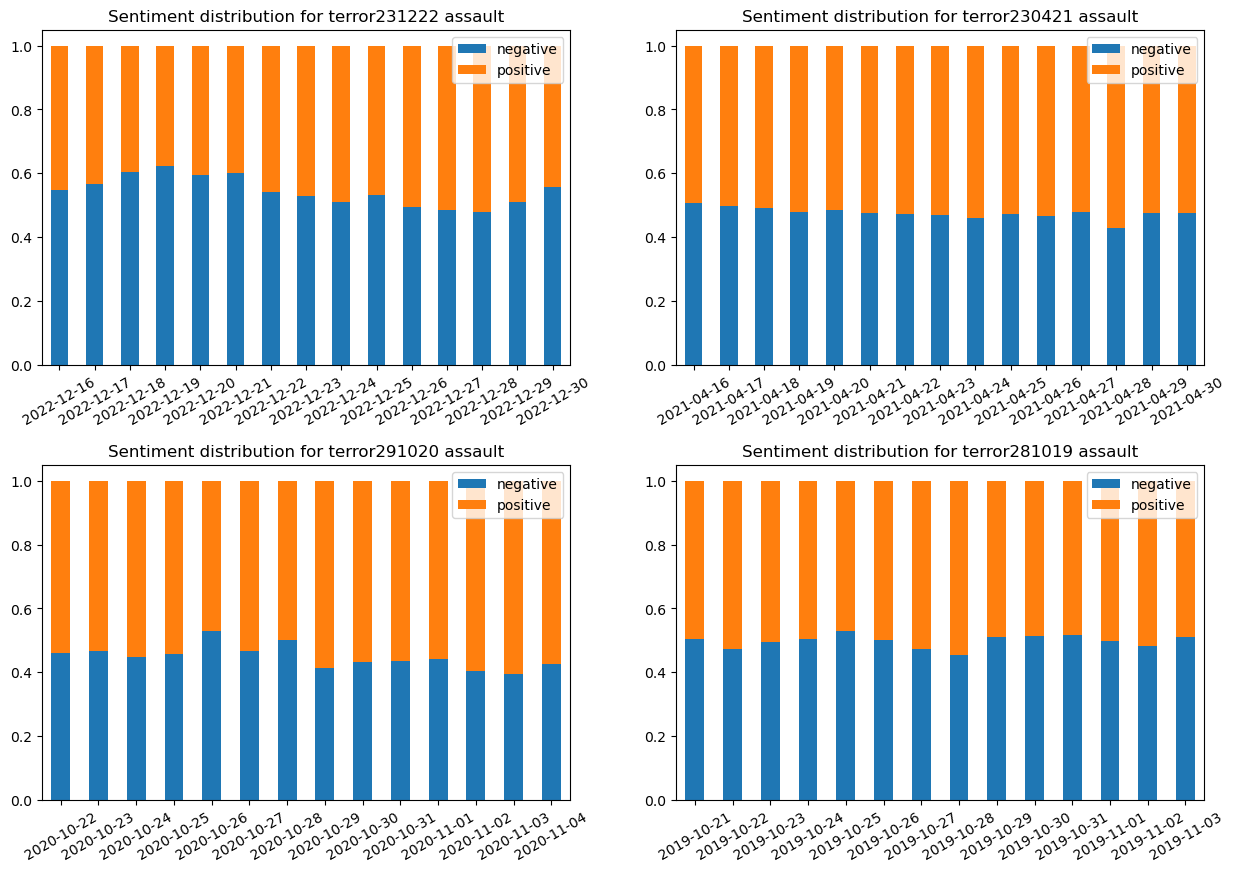

In [25]:
# for each dataset, group by date and plot the filled barplot of sentiment score for each date as subplots
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
for dataset, ax in zip(terror_nodups['dataset'].unique(), axes.flatten()):
    terror_nodups[terror_nodups['dataset'] == dataset].groupby('date')['sentiment_tf'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax, title=f'Sentiment distribution for {dataset} assault')
    ax.set_xlabel('')
    ax.set_ylabel('')
    xlabels = ax.get_xticklabels() 
    ax.set_xticklabels(xlabels, rotation=30)
    ax.legend(loc='upper right')


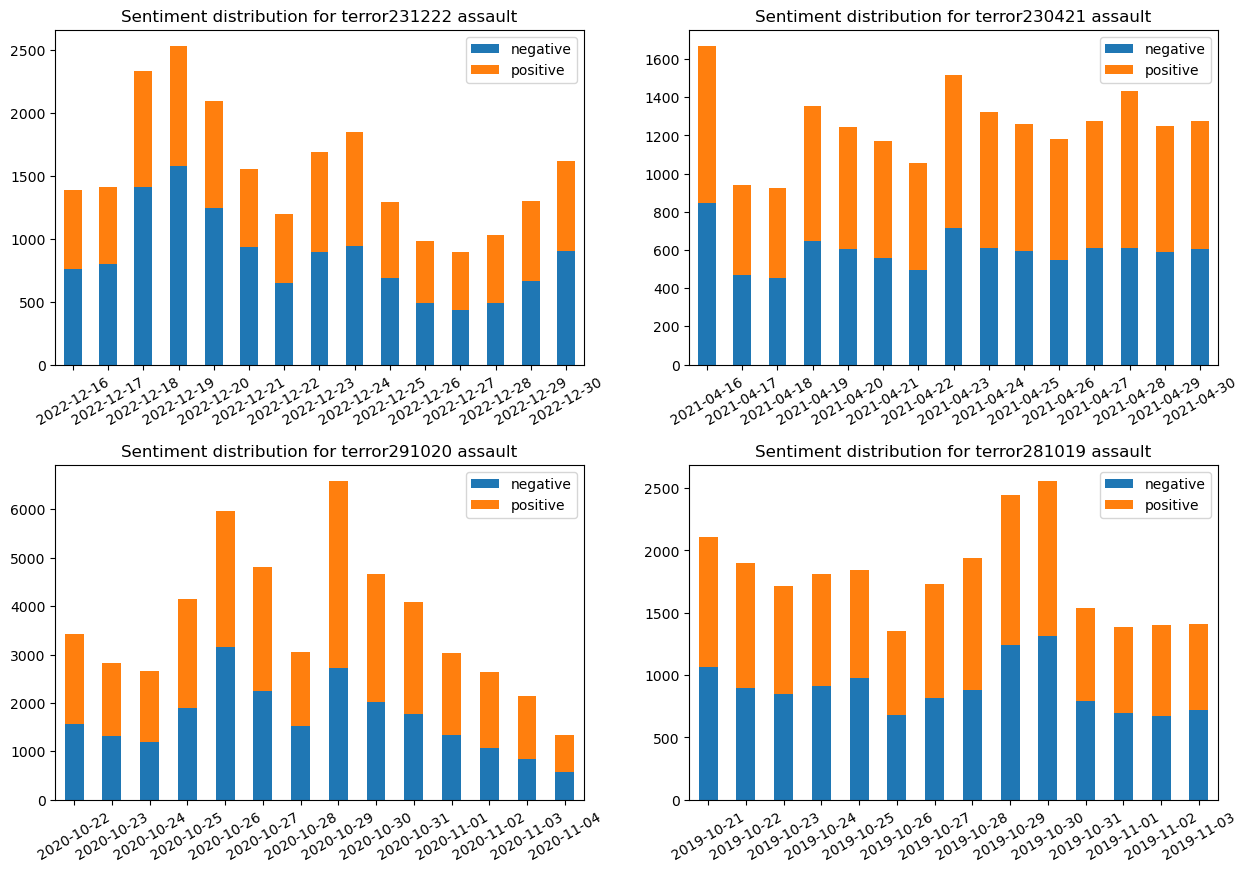

In [26]:
# for each dataset, group by date and plot the filled barplot of sentiment score for each date as subplots
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
for dataset, ax in zip(terror_nodups['dataset'].unique(), axes.flatten()):
    terror_nodups[terror_nodups['dataset'] == dataset].groupby('date')['sentiment_tf'].value_counts().unstack().plot(kind='bar', stacked=True, ax=ax, title=f'Sentiment distribution for {dataset} assault')
    ax.set_xlabel('')
    ax.set_ylabel('')
    xlabels = ax.get_xticklabels() 
    ax.set_xticklabels(xlabels, rotation=30)
    ax.legend(loc='upper right')

In [31]:
# one more step - with our own coding